In [624]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from xgboost import plot_importance
from numpy import sort
from sklearn.feature_selection import SelectFromModel

In [38]:
df = pd.read_excel('train.xlsx')

In [39]:
df = df.drop_duplicates()
df = df.dropna(subset=['goal'])
df = df[~df.iloc[:,:14].duplicated(keep=False)]

In [40]:
df_mean = df.sample(n=100000).mean()

In [100]:
df_1 = df[(df['depth, m']>2000)&(df.goal==1)].fillna(df_mean)
df_0 = df[(df['depth, m']>2000)&(df.goal==0)].fillna(df_mean).sample(n= int(len(df_1)*1.5))
df_train = pd.concat((df_0, df_1))

In [101]:
X = df_train[df_train.columns[~df_train.columns.isin(['well id', 'lith', 'goal'])]].values
y = df_train['goal'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [102]:
%%time
model = XGBClassifier(n_jobs=-1, n_estimators=900, max_depth=14)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("f1_score: %.2f%%" % (f1 * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1_score: 92.51%
Accuracy: 93.94%
CPU times: user 4min 14s, sys: 1.47 s, total: 4min 16s
Wall time: 4min 20s


f1_score: 92.64%
Accuracy: 94.04%
CPU times: user 4min 25s, sys: 1.07 s, total: 4min 26s
Wall time: 4min 32s

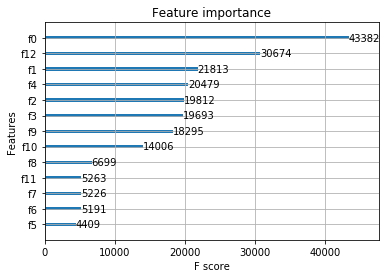

In [44]:
plot_importance(model)
plt.show()

In [135]:
pd.DataFrame(df_train[df_train.columns[~df_train.columns.isin(['well id', 'lith', 'goal'])]].columns).iloc[[0,1,2,3,4,9,12],:]

,0
0,"depth, m"
1,bk
2,GZ1
3,GZ2
4,GZ3
9,NKTD
12,ALPS


In [118]:
temp_ = pd.DataFrame(df.columns[~df.columns.isin(['well id', 'lith', 'goal'])]).iloc[[0,1,2,3,4,9,12],:]
X = df_train[list(temp_[0])].values
y = df_train['goal'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Тестились различные парамаетры XGBClassifier, GridSearchCV дал лучший результать для данных n_estimators и max_depth

In [119]:
%%time
model = XGBClassifier(n_jobs=-1, n_estimators=1100, max_depth=14)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("f1_score: %.2f%%" % (f1 * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1_score: 91.11%
Accuracy: 92.77%
CPU times: user 3min 21s, sys: 1.2 s, total: 3min 22s
Wall time: 3min 25s


In [643]:
precision_score(y_test, predictions)

0.8982417447773081

In [626]:
recall_score(y_test, predictions)

0.9244057751718051

In [120]:
roc_auc_score(y_test, predictions)

0.9271621720042815

### Тестовая выборка

In [648]:
df_test = pd.read_excel('test.xlsx')

In [105]:
set(df_test['well id'])

{47, 95, 126, 164, 176}

In [649]:
df_test = df_test.fillna(df_mean)
df_test = df_test.drop('id', axis = 1)

In [650]:
df_test['prediction']=0

In [651]:
temp_t = pd.DataFrame(df_test.columns[~df_test.columns.isin(['well id', 'lith', 'goal'])]).iloc[[0,1,2,3,4,9,12],:]
X_t = df_test[list(temp_t[0])][df_test['depth, m']>2000].values

In [652]:
X_t.shape

(13238, 7)

In [653]:
y_pred_t = model.predict(X_t)

In [654]:
df_test['prediction'][df_test['depth, m']>2000] = y_pred_t

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Результат

In [659]:
df_test['prediction'].to_excel('result_sinepsys.xlsx')

## =================================================

### Графики и вспомогательные вещи

In [660]:
temp_3 = list(temp_[0])

In [661]:
temp_3.extend(['well id', 'prediction'])

In [662]:
list(df_plots.columns[1:-2])

['bk', 'GZ1', 'GZ2', 'GZ3', 'NKTD', 'ALPS']

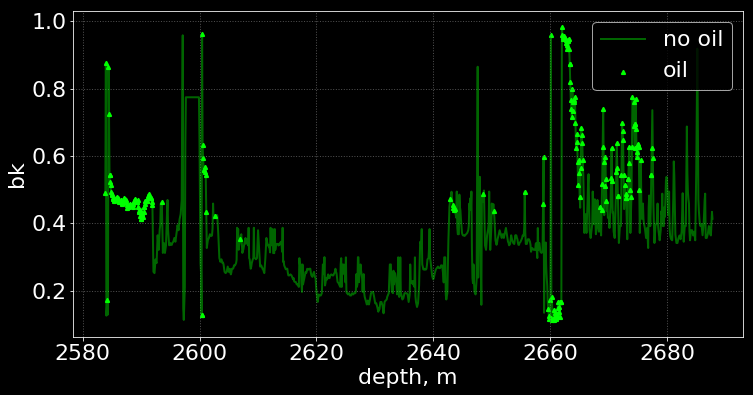

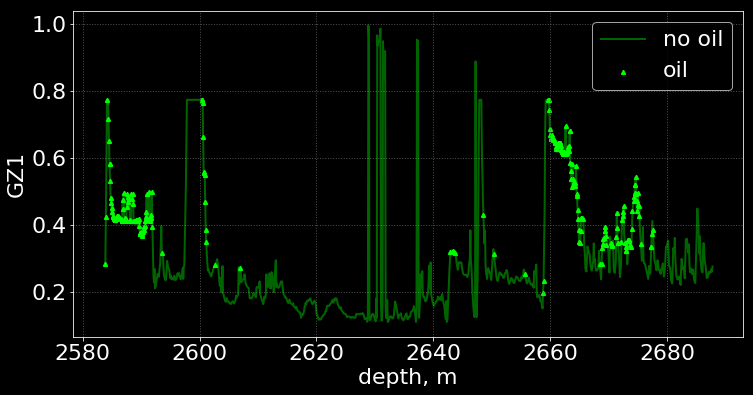

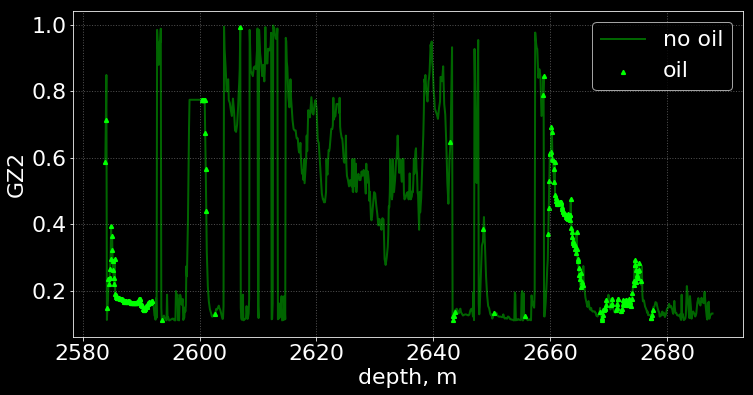

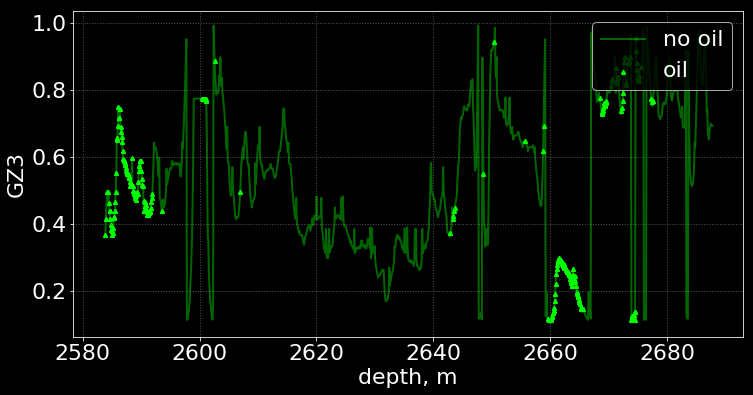

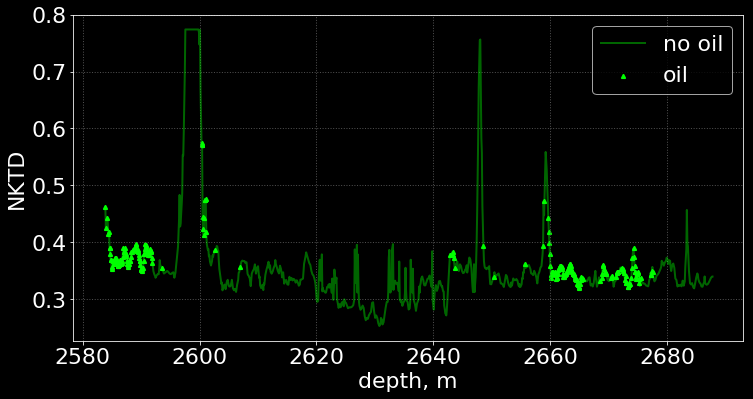

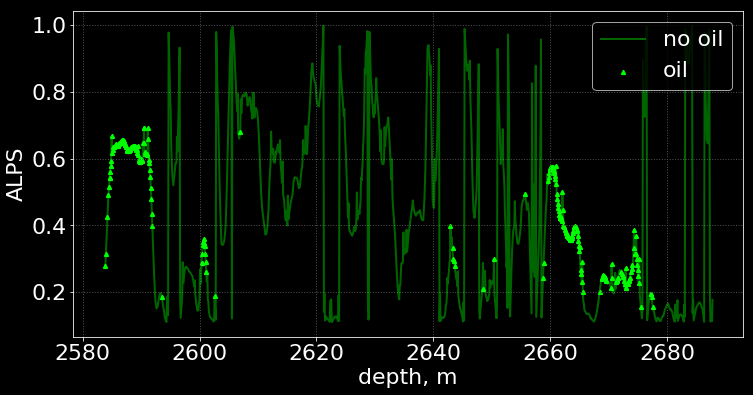

In [667]:
id_well = 95
df_plots = df_test[temp_3][df_test['well id']==id_well]
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})
#ax = plt.subplot(111)
t1 = df_plots['depth, m']
for n in list(df_plots.columns[1:-2]):
    plt.figure(figsize=(12,6))
    #t1 = list(range(len(df_plots[n][df_plots['well id']==47])))
    plt.plot(t1, df_plots[n], color='#00FF00',linewidth=2.0, alpha=0.4)
    plt.scatter(t1[df_plots['prediction']==1], 
                df_plots[n][df_plots['prediction']==1], 
                color='#00FF00',
                linewidth=2.0, 
                marker = '^', 
                s=10)
    plt.legend(['no oil','oil'], loc='upper right')
    plt.xlabel("depth, m")
    plt.ylabel(n)
    plt.grid(color='#505050', linestyle=':', linewidth=1, which='both')
    
    name = str(str(n) + '_' + str(id_well)) + '.png'
    plt.savefig(name)
    plt.show()
#leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
#leg.get_frame().set_alpha(0.5)




In [189]:
list(set(df_test['well id']))

[164, 47, 176, 126, 95]

In [671]:
for n in list(set(df_test[df_test['depth, m']>2000]['well id'])):
    ones = len(df_test[df_test['depth, m']>2000][(df_test['well id']==n)&(df_test['prediction']==1)])
    zeros = len(df_test[df_test['depth, m']>2000][(df_test['well id']==n)&(df_test['prediction']==0)])
    print('------------------------\n', n,  ':\n', 'ones: ', ones, 'zeros: ', zeros)

------------------------
 164 :
 ones:  724 zeros:  3210
------------------------
 47 :
 ones:  433 zeros:  927
------------------------
 176 :
 ones:  292 zeros:  882
------------------------
 126 :
 ones:  445 zeros:  5126
------------------------
 95 :
 ones:  236 zeros:  963


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


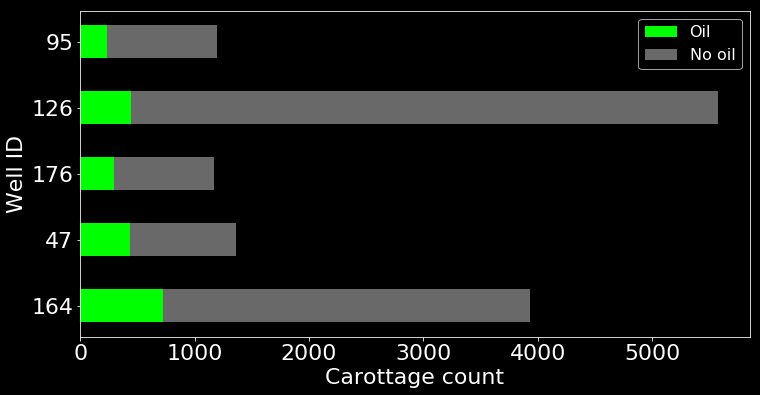

In [672]:
color = ['#00FF00', '#696969']
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,6))
for i in [0,1]:
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    labels = list(results.keys())
    plt.barh(labels, widths, left=starts, height=0.5, color = color[i])
    plt.legend(['Oil', 'No oil'], fontsize=16)
plt.xlabel('Carottage count')
plt.ylabel('Well ID')
plt.savefig('all_well.png')
plt.show()

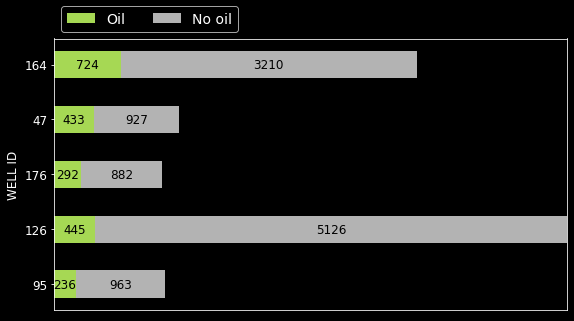

In [673]:
category_names = ['Oil', 'No oil']
results = {
    '164': [724, 3210],
    '47': [433, 927],
    '176': [292,882],
    '126': [445, 5126],
    '95': [236, 963],
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    plt.rcParams.update({'font.size': 12})
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('Set2')(
        np.linspace(0.6, 1, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'black' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=14)

    return fig, ax


survey(results, category_names)
plt.ylabel('WELL ID')
#plt.savefig('all_wells.png')
plt.show()

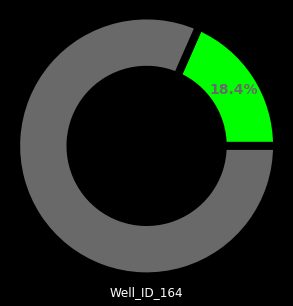

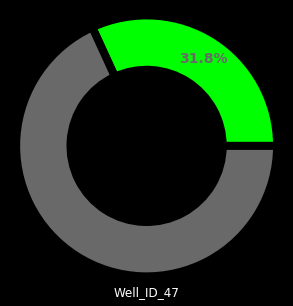

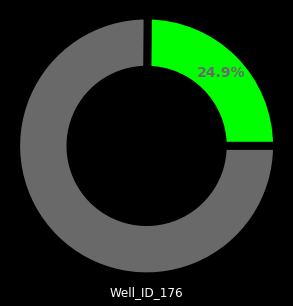

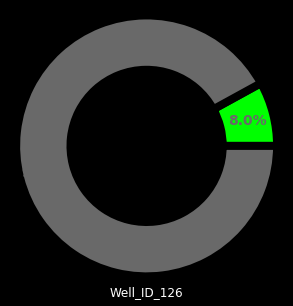

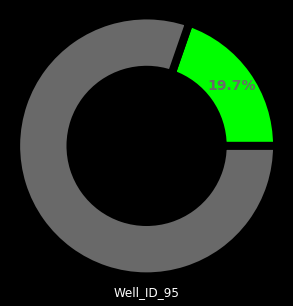

In [674]:
for el in list(results.keys()) :
    
    plt.figure(figsize=(5,5))
    plt.pie(results[el], 
            radius=1.2,
            autopct= '%1.1f%%', 
            pctdistance=0.8,
            textprops={'size': 14, 'color': '#696969', 'weight': 'semibold'}, 
            colors=['#00FF00', '#696969'], 
            wedgeprops = dict(width=0.5, 
                              edgecolor='black', 
                              linewidth = 8))
    name = 'Well_ID_' + el
    plt.xlabel(name)
    plt.savefig(name + '.png')
    plt.show()

### Экономика

In [692]:
out_sum=0
for el in list(results.keys()) :
    out = results[el][0]*0.7*100*4150*860*0.0895-(results[el][0]+results[el][1])*0.0895*(2450+2050*3+2050+1150)
    out_sum += out
    print(el, ': ', out/1000000)

164 :  16184.329642599996
47 :  9680.350608999997
176 :  6527.817358599998
126 :  9944.2207919
95 :  5275.6429961


In [693]:
out_sum = out_sum/1000000000
print("Income: %.2f млрд.руб" %out_sum)

Income: 47.61 млрд.руб
